# Project 2: Regression for Prediction Problems
Team members: Hero Ashman, Madeleine Parker, Elleni Hailu, Yael Nidam.

This reports outlines the steps to explore and analyze goverment data to better understand the prevelance of diabetes in Alabama, and ultimately inform decisions about where to target a pilot diabetes prevention program.

We use data from the Center for Disease Control and Prevention (CDC) and the US Census Bureau American Community Survey (ACS) to predict diabetes rates at the county level.

#### Report overview:

1. Preliminary data cleaning
2. Exploratory data analysis.
3. Data perperation for machnine learning models.
4. Train 5 Machine learning models.
5. Validate and refine models.
6. Discussion


## 1. Preliminary data Cleaning

### 1.1 Import libraries and explore data shape

In [1]:
import warnings
warnings.filterwarnings('ignore')

#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(10)
#%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


In [2]:
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv")
diabetes.head(3)

,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,...,sex and age_total population_21 years and over,sex and age_total population_62 years and over,sex and age_total population_65 years and over,sex and age_total population_18 years and over_1,sex and age_total population_18 years and over_male,sex and age_total population_18 years and over_female,sex and age_total population_18 years and over_sex ratio (males per 100 females),sex and age_total population_65 years and over_1,sex and age_total population_65 years and over_male,sex and age_total population_65 years and over_female
0,Autauga County,Alabama,1001,5178,13489,12525,76.5,55200,54170,1030,...,39614,9403,8050,41831,20054,21777,92.1,8050,3488,4562
1,Baldwin County,Alabama,1003,16707,48542,40024,86.6,208107,204535,3572,...,155502,49811,40665,162430,78104,84326,92.6,40665,18870,21795
2,Barbour County,Alabama,1005,3400,8009,5431,76.2,25782,25429,353,...,19394,5658,4634,20346,10923,9423,115.9,4634,2004,2630


In [3]:
# number of rows and columns
diabetes.shape

(3220, 95)

In [4]:
#View all column names
#cols = diabetes.columns.tolist()
#cols
#for i in range(len(cols)):
#    print(i,cols[i])

#[diabetes.columns.get_loc(c) for c in cols if c in diabetes]

# list of variable names (long)
#list(diabetes.columns.values)

### 1.2 Ensure that all datatypes other than the counry and state names are numeric.

In [5]:
#Checkout all datatypes that are object
diabetes.loc[:, diabetes.dtypes == np.object].head(3)

,County,State,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females)
0,Autauga County,Alabama,5178,13489,12525,76.5
1,Baldwin County,Alabama,16707,48542,40024,86.6
2,Barbour County,Alabama,3400,8009,5431,76.2


The counts for diabetes, people who are obese, people who are inactive, and the male to female sex ratio for people over aged 65 years old are strings. Some of these columns contain missing data, which is recorded as the string "No Data". We convert these columns to floats, coercing any rows with non-numeric strings in to NaN.  

In [6]:
diabetes['Diabetes_Number'] = pd.to_numeric(arg=diabetes['Diabetes_Number'], errors='coerce')
diabetes['Obesity_Number'] = pd.to_numeric(arg=diabetes['Obesity_Number'], errors='coerce')
diabetes['Physical_Inactivity_Number'] = pd.to_numeric(arg=diabetes['Physical_Inactivity_Number'], errors='coerce')
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = pd.to_numeric(arg=diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'], errors='coerce')

#using the same command to check there are no obtect type columns
diabetes.loc[:, diabetes.dtypes == np.object].head(3)

,County,State
0,Autauga County,Alabama
1,Baldwin County,Alabama
2,Barbour County,Alabama


### 1.3 Check missing counts for key variables

In [7]:
print(diabetes.isnull().sum().sum())
diabetes.columns[diabetes.isnull().any()]


186


Index(['Diabetes_Number', 'Obesity_Number', 'Physical_Inactivity_Number',
       'sex and age_total population_65 years and over_sex ratio (males per 100 females)'],
      dtype='object')

In total, there are 186 missing values in our data. Predictors with missing values are diabetes_number, obesisty_number, physical_inactivity_number, and sex_ratio_over_65. There is 1 row with missing diabetes counts. There are 78 rows with missing counts for Physically Inactive and Obese. There are 29 missing values for the sex ratio over 65yrs old. in the code below we drop rows with missing values for features that will be used in the models.

In [8]:
diabetes.isnull().sum()[3:7]
diabetes = diabetes.dropna(subset=['Diabetes_Number','Obesity_Number','Physical_Inactivity_Number','sex and age_total population_65 years and over_sex ratio (males per 100 females)'])
diabetes.shape


(3112, 95)

## 2. Exploratory Data Analysis
Our data set is a combination of variables from the CDC and the ACS at the county level. We have information from 3220 counties. Variables include the population counts of people with diabetes, who are obese, and who are physically inactive, and population counts of people by race, ethnicity, age, and sex. 

**Distribution of Diabetes Cases** 

We start our report with some descriptive plots. Our goal here is to explore variation in diabetes numbers across counties. We also look at a couple of predictors that we suspect might be important for prediction later on.  

We plot a histogram of diabetes cases as the county level. We plot this both as number of cases and as number of cases per 100 people, as the counties vary in population size. 

In [9]:
# calculate diabetes cases per 100 people
diabetes['diabetes_per1000'] = diabetes['Diabetes_Number']/diabetes['race_total population']*1000

# calculate diabetes cases per 100 people
diabetes['physical_inactivity_per1000'] = diabetes['Physical_Inactivity_Number']/diabetes['race_total population']*1000

# calculate diabetes cases per 100 people
diabetes['obesity_per1000'] = diabetes['Obesity_Number']/diabetes['race_total population']*1000

The plot below shows that the percentage of people with diabetes is roughly normally distributed across counties, with a mean around 10%. This corresponds to the percentage of the population with diabetes reported by the [American Diabetes Association](https://www.diabetes.org/resources/statistics/statistics-about-diabetes). 

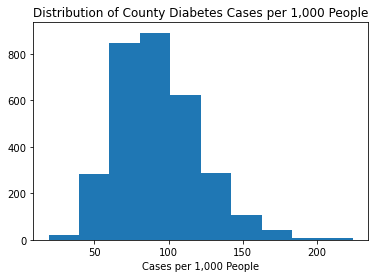

In [10]:
# diabetes per 100 people
#sns.histplot(data = diabetes, x = 'diabetes_per100', kde = True)
plt.hist(diabetes["diabetes_per1000"])
plt.title("Distribution of County Diabetes Cases per 1,000 People")
plt.xlabel("Cases per 1,000 People");

**Diabetes and Level of Inactivity**

We suspect there might be a relationship between diabetes and level of inactivity. To explore this, we plot the linear regression line of physical inactivity on diabetes cases, at the county level. We report both numbers per 1000 people. The plot below also includes a scatter plot of the underlying data. There is a linear relationship between number of diabetes cases and number of people who are physically inactive. There is greater variation around the middle of the distribution. This implies that the number of inactive people might not be a good linear predictor for the number of diabetes cases in counties with cases around the middle of the distribution. 

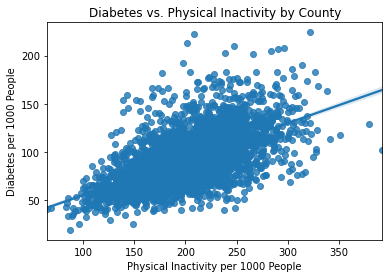

In [11]:
sns.regplot(data = diabetes, x ='physical_inactivity_per1000' , y = 'diabetes_per1000', scatter = True)
plt.title("Diabetes vs. Physical Inactivity by County")
plt.xlabel("Physical Inactivity per 1000 People")
plt.ylabel("Diabetes per 1000 People");

__Diabetes and obesity__

There is similarly a linear relationship between diabetes cases and the number of obese people at the county level. Again, this relationship seems weakest around the middle of the distribution, where there is greater variation, and it is not clear that increasing cases of obesity would predict increasing cases of diabetes. 

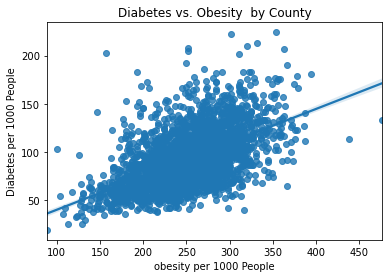

In [12]:
sns.regplot(data = diabetes, x ='obesity_per1000' , y ='diabetes_per1000' , scatter = True)
plt.title("Diabetes vs. Obesity  by County")
plt.xlabel("obesity per 1000 People")
plt.ylabel("Diabetes per 1000 People");

**Diabetes and Demographic Characteristics**

Our data contains county population counts by sex, race, and age (and interactions of all three). It is possible that upstream social factors that vary by gender, such as diet or activity levels, impact rates of diabetes. Although we do not observe the rates of diabetes differentially for men and women (the only genders reported in the ACS), we can see if counties with a higher male to female ratio have higher or lower rates of diabetes. For this, we create a dummy variable indicating if a county has more or equal number of women than men (female_cnty). We then plot a box-and-whisker diagram of cases per 100 people for the two types of county.

The plot below shows that for counties with equal or higher numbers of women than men, their rate of diabetes is slightly higher (orange plot). However, there is not a large difference and it may not be significant.  


In [13]:
# dummy for a county having more or equal number of women to men
diabetes['female_cnty'] = 1*(diabetes['sex and age_total population_sex ratio (males per 100 females)'] <=100) \
+ 0*(diabetes['sex and age_total population_sex ratio (males per 100 females)'] > 100)
#diabetes['female_cnty']

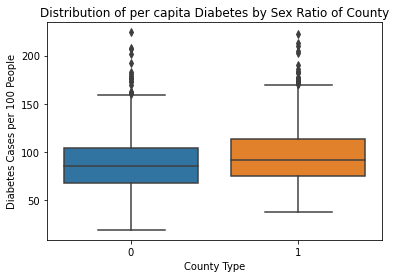

In [14]:
sns.boxplot(data = diabetes, x = 'female_cnty', y = 'diabetes_per1000')
plt.title('Distribution of per capita Diabetes by Sex Ratio of County')
plt.xlabel('County Type')
plt.ylabel('Diabetes Cases per 100 People');

## 3. Data perperation for machine learning models.

In this next section we prepare the data so we can use it to fir machine learning models. Our process includes additional data cleaning steps, data partition, and preliminary feature selection.

### 3.1 Feature Selection

We examine the correlation of the sociodemographic variables included in the sample and select only ones with low correltation with one another. Because much of the variables in regards to the racial composition and the sex distribution in the counties are related, not doing so will lead our models to not converge. Hence, driven both by prior literature/theory and the correlation of these variables in our dataset, we select obesity and physical activity counts per capita, the distribution of each broadly defined racial group (white, Black/African American, American Indian/Aaska Native, Native Hawaiian/Pacific Islander, and Hispanic/Latino), eligible voters, the sex ratio of the entire population, and total housing units in each county. Although limited, we believe these features will allow us to estimate the influence of historical and institutional practices that continue to disproportionately burden marginalized populations around the country, while using physical inactivity and obesity counts as a proxy to account for the availablility of health promoting resources. Total housing is potentially a proxy for wealth. 

There are various variables reporting counts of people by race. We use the "race alone or in combination with one or more other races", which includes in each category people who report one or more race. These categories sum together to the total population. We exclude the category "other race". We convert each of the race count variables to percentages, so that rather than capturing the count of people of a given race, we capture the distribution of people across different races. This controls for the fact that counties vary in population size. 

In [15]:
diabetes_clean = diabetes[[
                            'diabetes_per1000'
                           ,'physical_inactivity_per1000'
                           ,'obesity_per1000'
                           ,'sex and age_total population_65 years and over_sex ratio (males per 100 females)'
                           , 'race alone or in combination with one or more other races_total population'
                           , 'race alone or in combination with one or more other races_total population_white'
                           , 'race alone or in combination with one or more other races_total population_black or african american'
                           , 'race alone or in combination with one or more other races_total population_american indian and alaska native'
                           , 'race alone or in combination with one or more other races_total population_asian'
                           , 'race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander'
                           , 'race alone or in combination with one or more other races_total population_some other race'
                           , 'hispanic or latino and race_total population_hispanic or latino (of any race)'
                           , 'sex and age_total population_65 years and over_1'
                           , 'sex and age_total population_65 years and over_male'
                           , 'sex and age_total population_65 years and over_female'
                           , 'sex and age_total population', 'sex and age_total population_male'
                           , 'sex and age_total population_female'
                           , 'sex and age_total population_sex ratio (males per 100 females)'
                           , 'sex and age_total population_under 5 years'
                           , 'sex and age_total population_5 to 9 years'
                           , 'sex and age_total population_10 to 14 years'
                           , 'sex and age_total population_15 to 19 years'
                           , 'sex and age_total population_20 to 24 years'
                           , 'sex and age_total population_25 to 34 years'
                           , 'sex and age_total population_35 to 44 years'
                           , 'sex and age_total population_45 to 54 years'
                           , 'sex and age_total population_55 to 59 years'
                           , 'sex and age_total population_60 to 64 years'
                           , 'sex and age_total population_65 to 74 years'
                           , 'sex and age_total population_75 to 84 years'
                           , 'sex and age_total population_85 years and over'
                           , 'sex and age_total population_median age (years)'
                           , 'total housing units'
                           , 'citizen -  voting age population_citizen -  18 and over population' 
                          ]]
diabetes_clean.shape

(3112, 35)

### 3.2 Additional Data Cleaning and preparation

In [16]:
# convert count variables to percents
diabetes_clean.loc[:,'pct_white'] = diabetes_clean['race alone or in combination with one or more other races_total population_white']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_black'] = diabetes_clean['race alone or in combination with one or more other races_total population_black or african american']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_native'] = diabetes_clean['race alone or in combination with one or more other races_total population_american indian and alaska native']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_asian'] = diabetes_clean['race alone or in combination with one or more other races_total population_asian']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_pacisl'] = diabetes_clean['race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_other'] = diabetes_clean['race alone or in combination with one or more other races_total population_some other race']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_hispan'] = diabetes_clean['hispanic or latino and race_total population_hispanic or latino (of any race)']/diabetes_clean['race alone or in combination with one or more other races_total population']

diabetes_clean.loc[:,'pct_under5'] = diabetes_clean['sex and age_total population_under 5 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_5_to_9'] = diabetes_clean['sex and age_total population_5 to 9 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_10_to_14'] = diabetes_clean['sex and age_total population_10 to 14 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_15_to_19'] = diabetes_clean['sex and age_total population_15 to 19 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_20_to_24'] = diabetes_clean['sex and age_total population_20 to 24 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_25_to_34'] = diabetes_clean[ 'sex and age_total population_25 to 34 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_35_to_44'] = diabetes_clean[ 'sex and age_total population_35 to 44 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_45_to_54'] = diabetes_clean[ 'sex and age_total population_45 to 54 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_55_to_59'] = diabetes_clean['sex and age_total population_55 to 59 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_60_to_64'] = diabetes_clean[ 'sex and age_total population_60 to 64 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_65_to_74'] = diabetes_clean[ 'sex and age_total population_65 to 74 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_75_to_84'] = diabetes_clean[ 'sex and age_total population_75 to 84 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_85_over'] = diabetes_clean[ 'sex and age_total population_85 years and over']/diabetes_clean['race alone or in combination with one or more other races_total population']

diabetes_clean.loc[:,'pct_male'] = diabetes_clean['sex and age_total population_male']/diabetes_clean['sex and age_total population']
diabetes_clean.loc[:,'pct_female'] = diabetes_clean['sex and age_total population_female']/diabetes_clean['sex and age_total population']  
diabetes_clean.loc[:,'houses_per_capita'] = diabetes_clean['total housing units']/diabetes_clean['sex and age_total population']
diabetes_clean.loc[:,'citizens_per_capita'] = diabetes_clean['citizen -  voting age population_citizen -  18 and over population']/diabetes_clean['sex and age_total population']

diabetes_clean.head(3)

,diabetes_per1000,physical_inactivity_per1000,obesity_per1000,sex and age_total population_65 years and over_sex ratio (males per 100 females),race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,...,pct_45_to_54,pct_55_to_59,pct_60_to_64,pct_65_to_74,pct_75_to_84,pct_85_over,pct_male,pct_female,houses_per_capita,citizens_per_capita
0,93.804348,226.902174,244.365942,76.5,55200,43367,10962,464,895,115,...,0.142264,0.074837,0.048804,0.085344,0.045725,0.014764,0.486848,0.513152,0.422373,0.748261
1,80.280817,192.324141,233.255008,86.6,208107,182689,20311,3185,2824,79,...,0.136132,0.069387,0.071362,0.117973,0.058456,0.018976,0.486231,0.513769,0.537920,0.764957
2,131.874952,210.650842,310.643084,76.2,25782,12461,12492,301,155,1,...,0.133892,0.064270,0.064037,0.109379,0.053991,0.016368,0.531262,0.468738,0.462997,0.775386


Preparation for logistic regression: We create a binary variable for high diabetes cases indicator based on median split and separating the response from the features:

In [17]:
# create a binary variable for logistic regression
diabetes_clean.describe() #median of Diabetes counts is 89.29 [high diabetes: >89.29 and low diabetes <=89.29]
diabetes_clean.loc[diabetes_clean['diabetes_per1000'] < 89.29, 'diabetes_cat'] = "< 89.29"
diabetes_clean.loc[diabetes_clean['diabetes_per1000'] >= 89.29, 'diabetes_cat'] = ">= 89.29"

from sklearn.preprocessing import LabelBinarizer

lb_style = LabelBinarizer()
diabetes_clean.loc[:,'diabetes_binary'] = lb_style.fit_transform(diabetes_clean.loc[:,"diabetes_cat"])
diabetes_clean.head(3)

,diabetes_per1000,physical_inactivity_per1000,obesity_per1000,sex and age_total population_65 years and over_sex ratio (males per 100 females),race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,...,pct_60_to_64,pct_65_to_74,pct_75_to_84,pct_85_over,pct_male,pct_female,houses_per_capita,citizens_per_capita,diabetes_cat,diabetes_binary
0,93.804348,226.902174,244.365942,76.5,55200,43367,10962,464,895,115,...,0.048804,0.085344,0.045725,0.014764,0.486848,0.513152,0.422373,0.748261,>= 89.29,1
1,80.280817,192.324141,233.255008,86.6,208107,182689,20311,3185,2824,79,...,0.071362,0.117973,0.058456,0.018976,0.486231,0.513769,0.537920,0.764957,< 89.29,0
2,131.874952,210.650842,310.643084,76.2,25782,12461,12492,301,155,1,...,0.064037,0.109379,0.053991,0.016368,0.531262,0.468738,0.462997,0.775386,>= 89.29,1


In [18]:
# We create a final clean dataset with all the features renamed and set as a rate/percentage to account for population size.
diabetes_clean2 = diabetes_clean[['diabetes_per1000',
                                 'physical_inactivity_per1000',
                                 'obesity_per1000','diabetes_binary',
                                 'pct_white',
                                 'pct_black',
                                 'pct_native',
                                 'pct_asian',
                                 'pct_pacisl',
                                 'pct_other',
                                 'pct_hispan',
                                 'pct_under5',
                                 'pct_5_to_9',
                                 'pct_10_to_14',
                                 'pct_15_to_19',
                                 'pct_20_to_24',
                                 'pct_25_to_34',
                                 'pct_35_to_44',
                                 'pct_45_to_54',
                                 'pct_55_to_59',
                                 'pct_60_to_64',
                                 'pct_65_to_74',
                                 'pct_75_to_84',
                                 'pct_85_over',
                                 'pct_male',
                                 #'pct_female',
                                 'houses_per_capita',
                                 'citizens_per_capita']]
diabetes_clean2.head()

,diabetes_per1000,physical_inactivity_per1000,obesity_per1000,diabetes_binary,pct_white,pct_black,pct_native,pct_asian,pct_pacisl,pct_other,...,pct_35_to_44,pct_45_to_54,pct_55_to_59,pct_60_to_64,pct_65_to_74,pct_75_to_84,pct_85_over,pct_male,houses_per_capita,citizens_per_capita
0,93.804348,226.902174,244.365942,1,0.785634,0.198587,0.008406,0.016214,0.002083,0.007736,...,0.133587,0.142264,0.074837,0.048804,0.085344,0.045725,0.014764,0.486848,0.422373,0.748261
1,80.280817,192.324141,233.255008,0,0.877861,0.097599,0.015305,0.013570,0.000380,0.012724,...,0.121942,0.136132,0.069387,0.071362,0.117973,0.058456,0.018976,0.486231,0.537920,0.764957
2,131.874952,210.650842,310.643084,1,0.483322,0.484524,0.011675,0.006012,0.000039,0.031029,...,0.120394,0.133892,0.064270,0.064037,0.109379,0.053991,0.016368,0.531262,0.462997,0.775386
3,105.251476,258.667377,290.051938,1,0.774493,0.227150,0.003995,0.002264,0.000000,0.000400,...,0.128512,0.152661,0.066320,0.053980,0.094198,0.049363,0.018955,0.539442,0.406668,0.784481
4,108.977361,249.197675,246.803712,1,0.971134,0.019499,0.012386,0.005065,0.000919,0.008309,...,0.124087,0.137861,0.067569,0.062677,0.106375,0.056119,0.015023,0.493260,0.420193,0.739474


We standertize our dataset by applying the maximum absolute scaling function, which rescales each feature between -1 and 1 by dividing every observation by its maximum absolute value.

In [19]:
#from: https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475

# apply the maximum absolute scaling in Pandas using the .abs() and .max() methods
def maximum_absolute_scaling(df):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in df_scaled.columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled
    
# call the maximum_absolute_scaling function
diabetes_clean2 = maximum_absolute_scaling(diabetes_clean2)

In [20]:
#pd.set_option('display.max_rows', None)
#diabetes_clean.corr()
#diabetes_clean.corr()['race_total population']
#diabetes_clean.corr()['total housing units']
#diabetes_clean.corr()['race alone or in combination with one or more other races_total population_white']
#diabetes_clean.corr()['race_total population_one race_white']
#diabetes_clean.corr()['race_total population_one race_black or african american']
#diabetes_clean.corr()['race_total population_one race_american indian and alaska native']
#diabetes_clean.corr()['race_total population_one race_asian']
#diabetes_clean.corr()['citizen -  voting age population_citizen -  18 and over population']
#diabetes_clean.corr()['sex and age_total population_sex ratio (males per 100 females)]

### 3.3 Partition Data

First, we specify our features and outcomes.

In [21]:
# parse data 
X = diabetes_clean2.drop(['diabetes_per1000', 'diabetes_binary'], axis=1)
Y = diabetes_clean2['diabetes_per1000'] # for all other models
Y1 = diabetes_clean2['diabetes_binary'] # for logistic regression

X.shape

(3112, 25)

#### Training Set

Since our dataset is small, we are interested in saving a relatively large portion (80%) of it for the training and validation sets, so that we can reduce overfitting. We also plan to fit validation models as well in order to tune the hyperparameters. The split out data 80:10:10 into training:validation:test data.

In [22]:
from sklearn.model_selection import train_test_split

# set the random seed to ensure that results are similar across different runs and machines. 
np.random.seed(10)

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    train_size=0.80, test_size=0.20)
# for logistic regression splitting the data 4 ways
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y1,
                                                    train_size=0.80, test_size=0.20)

print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X_test is", X_test.shape)
print("Shape of y_test is", y_test.shape)
print("Shape of y_train1 is", y_train.shape)
print("Shape of y_test1 is", y_test.shape)

Shape of X train is (2489, 25)
Shape of y_train is (2489,)
Shape of X_test is (623, 25)
Shape of y_test is (623,)
Shape of y_train1 is (2489,)
Shape of y_test1 is (623,)


#### Validation Set

In order to tune our hyperparamters, we also set aside a validation data set from the training data. We subset 75% of our training data as validaton data. This gives a total split of training:validation:test as 60:20:20. 

In [23]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)

# validation set for logistic regression
X_train1, X_validate1, y_train1, y_validate1 = train_test_split(X_train1, y_train1,
                                                    train_size=0.75, test_size=0.25)

print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X_validate is", X_validate.shape)
print("Shape of y_validate is", y_validate.shape)
print("Shape of y_train is", y_train1.shape)
print("Shape of y_validate is", y_validate1.shape)

Shape of X train is (1866, 25)
Shape of y_train is (1866,)
Shape of X_validate is (623, 25)
Shape of y_validate is (623,)
Shape of y_train is (1866,)
Shape of y_validate is (623,)


## 4. Train Models

### 4.1 Model Descriptions

#### OLS: Linear regression
Basic logic and assumptions underlying the model: 
Ordinary Least Squares regression works to predict an outcome variable based on one or more treatment variables, using training data to estimate coefficients for the model. It assumes a linear relationship between the treatment variables and the outcome variable. OLS fits coefficients using values that minimize the sum of the squared errors, the distance from the predicted outcomes to the actual outcomes. 
 
Pros: 
OLS is straightforward and easy to interpret (when there are a reasonable number of predictors). It isn’t dependent on the scale of its predictors.
 
Cons: 
OLS assumes a linear relationship between X and Y, not allowing for much flexibility in the model. It is prone to overfitting (and does not account for the number of variables used), and can run into issues if input variables are correlated. While it provides unbiased estimates, this is at the cost of high variance in the test data. 
 
Why it works for this problem: 
OLS regression works well for predicting continuous and numeric variables that have a linear relationship. Our problem involves continuous numeric variables, which allows us to use OLS. As it assumes linear relationships, it may not end up being the best fit (we dropped two of our predictors that were linearly related to our outcome as they were highly correlated with our other predictors). That being said, it can serve as a useful comparison point for our other models.
 
#### Logistic regression
Basic logic and assumptions underlying the model: 
Logistic regressions models the probability of Y being a certain binary outcome, given one or more input variables. Input variables are used to estimate coefficients that maximize a likelihood function.
 
Pros: 
Logistic regressions are simple and easy to understand and interpret (again, conditional on not having too many predictors).
 
Cons: 
Logistic regressions don’t perform well on non-linear data, or data with extraneous or correlated features. They may overfit when tasked with many features, and assume underlying linear relationships (between the logit of the outcome and each predictor), which means that it often is not the best method to use where complex relationships are involved. They are limited to binary outcomes.
 
Why it works for this problem: 
Logistic regression makes sense for binary classifications, which means that it isn’t a perfect fit for our problem. However, our problem can be framed in a binary way: whether or not a county has a high rate of diabetes, which allows us to use logistic regression but introduces judgment beforehand about what constitutes a “high” rate of diabetes.
 
#### Ridge
Basic logic and assumptions underlying the model: 
Ridge builds off of OLS by shrinking regression coefficients toward zero in order to penalize overfitting, using the sum of squared coefficients.
 
Pros: 
Reduction in variance from OLS (sometimes at the expense of an increase in bias). Ridge therefore works very well where there’s large variance.
 
Cons: 
Bias increases in the tradeoff made with a reduction in variance from OLS. Ridge is also easily affected by scale (we need to standardize coefficients to be of similar size). We can’t use it to do variable selection because it doesn’t shrink variables to be exactly zero.
 
Why it works for this problem: 
We can use Ridge for the same reasons that we can use OLS. Ridge often improves upon OLS, reducing variance, and depending on our data (if all predictor coefficients are of a similar size) it may be a better fit than Lasso. At this point, we don’t know which of the two would best fit our data.
 
#### Lasso
Basic logic and assumptions underlying the model: 
Similar to Ridge, Lasso shrinks regression coefficients toward zero by penalizing overfitting using the sum of the coefficients. Unlike Ridge, which uses all variables as predictors, Lasso can force some coefficient estimates to be exactly equal to zero, selecting only some variables to use as predictors.
 
Pros: 
Lasso is similar to Ridge, but produces simpler and more interpretable models. Lasso generally will perform better than Ridge where predictors are of very different sizes (in terms of bias and variance). It implicitly performs feature selection. 
 
Cons: 
Similar to OLS, Ridge, and Logistic regression, it is prone to overfitting and doesn’t handle extraneous or correlated features well. When there are many correlated features (predictors), it will keep only one but it’s choice of which one to keep is not clear. 
 
Why it works for this problem: 
Similar to Ridge, we are able to use Lasso to generate estimates that improve upon OLS by penalizing overfitting. Depending on our data, and the amount of variance in our predictors’ coefficient sizes,  it may be a better fit than Ridge. At this point, we don’t know which of the two would best fit our data.
 
#### Nearest neighbors regression
Basic logic and assumptions underlying the model: 
K-nearest neighbors makes predictions by identifying the observations in the dataset that are closest to the observation it is predicting, and assigning the new observation to the class that the majority of the most-similar observations (nearest neighbors) are in.
 
Pros: 
Nearest neighbors is simple and doesn’t assume relationships between variables (such as linear relationships assumed by the other models described).
 
Cons: 
Nearest neighbors is sensitive to outliers, and needs to use scaled data. It also can be difficult and slow with large datasets or those with many features. It doesn’t describe what predictors are most important – we don’t get information about coefficients or the like - so functions more as a black box.
 
Why it works for this problem: 
Nearest neighbors works for classification problems, and works best when there aren’t too many features, which is the case for our dataset. The fact that it does not assume any relationships between our variables makes it quite appealing.




### 4.2 Train Models
1. Linear Regression
2. Logistic Regression
3. Ridge Regression
4. Lasso
5. Nearest neighbors

Below, we train each model on the training set and predict our outcome on the validation set. We then assess how well our models fit the train data by reporting accuracy scores. Documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

We ran into some issues with logistic regression not converging and the OLS coefficients being very large in magnitude due to different scales of the variables. We therefore scaled all our variables to be mean zero and unit standard deviation. This is a necessary prior step when running Ridge and Lasso too.  

#### Process steps for each ML method:

We want to see how well each model fits the data. Using the training data, we fit each model and predict the response variable.  We calculate the mean squared error to understand how well the model fits the training data, and that will help us compare models. 

__Steps:__

1. Create object to store the ML method.
2. Fit the model on the training data.
3. Plot coefficients.
4. Predict on the training data
5. calcualte the RMSE
6. Tune hyperparameters where applicable.

In [24]:
# We define a function to estimate the Root-Mean-Square-Deviation for all models.
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

#### 1. OLS

In [25]:
# 1.create a model
lin_reg = LinearRegression()

# 2.fit the model
lin_model_train = lin_reg.fit(X_train, y_train)

# look at the coefficients
print(lin_model_train.coef_)
print(lin_model_train.intercept_)

[ 0.35412698  0.37026632 -0.24788628 -0.03721647 -0.06264475 -0.25161186
  0.18335424 -0.1284072   0.04398428 -0.01325938 -0.09367956 -0.01226792
  0.04296788 -0.11647933 -0.10674267  0.04711211  0.03419166 -0.05374265
 -0.09670563  0.20320363  0.05959193 -0.04616491 -0.22415021 -0.04747032
  0.07046492]
0.419898302127738


We can visualize the coefficients. There are many coefficients with large magnitudes. As our data has not yet been normalized, it is hard to know if this means they are important or not.

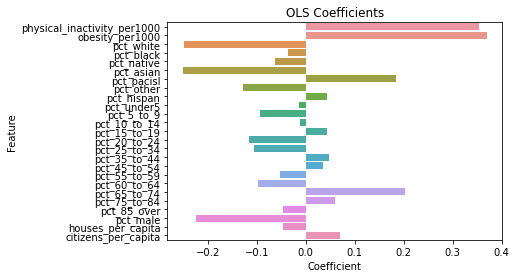

In [26]:
# 3. Plot coefficients 
# Create a dataframe with the coefficient and feature names
lin_reg_data = pd.DataFrame([lin_model_train.coef_, X.columns]).T
lin_reg_data.columns = ['Coefficient', 'Feature']
# Plot
ax = sns.barplot(data = lin_reg_data, y = 'Feature', x = 'Coefficient')
ax.set_title("OLS Coefficients")
plt.show()

We want to see how well this model fits our data. We predict our response variable from the training data and report the mean squared error, which will be used to compare this model with other models.

In [27]:
# 4. predict on the Training data
lin_pred_train = lin_model_train.predict(X_train)

# 5. calculate RMSE
rmse(lin_pred_train, y_train)

0.08591531671349957

Below we tune the hyperparameters of the OLS model. We will then use they hyperparameters on the validation set in 5.1.

In [28]:
# 6. Tune Hyperparameters
param_grid = {'fit_intercept': ['True', 'False'],
              'normalize': ['True', 'False']}
lin_grid_reg = GridSearchCV(lin_reg, param_grid, cv=5, iid=False)
lin_grid_reg=lin_grid_reg.fit(X_train, y_train)

best_lin_index = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])

# print out the best hyperparameters
print(lin_grid_reg.cv_results_["params"][best_lin_index])

{'fit_intercept': 'True', 'normalize': 'True'}


#### 2. Logistic Regression

In [29]:
# 1. create a model
log_reg = LogisticRegression(solver = 'lbfgs',max_iter=10000)

# 2. fit the model
log_model = log_reg.fit(X_train1, y_train1)

print(log_model.coef_)
print(log_model.intercept_)

[[ 6.67561452  5.48968562 -1.54464636  1.66595745  1.24496946 -2.90627724
  -0.29618669  0.28374335  0.16036985 -0.3507411  -1.25212373  0.27809309
  -0.2890387  -1.16708887 -0.82768646 -0.69086828  0.51418026 -0.03449022
  -0.69811385  2.3574656   1.46080675 -1.50820283 -0.75891668 -0.73410584
   1.68158624]]
[-4.83785275]


Examine the coefficients via visualization

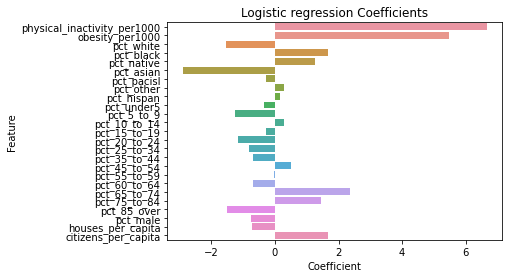

In [30]:
# 3. Plot Coefficients 
# Create a dataframe with the coefficient and feature names
log_reg_data = pd.DataFrame([log_model.coef_[0], X.columns]).T
log_reg_data.columns= ['Coefficient', 'Feature']
# Plot
ax = sns.barplot(x="Coefficient", y="Feature", data=log_reg_data)
ax.set_title("Logistic regression Coefficients")
plt.show()

In [31]:
# 4. Predict on the training data
log_pred = log_model.predict(X_train1)

# 5. Calculate RMSE
rmse(log_pred, y_train1)

0.462413631459417

Below we tune the hyperparameters of the Logistic Regression model

In [32]:
# 6. Tune Hyperparameters
param_grid = {'fit_intercept': [True, False],
             'max_iter': [1000]}
log_grid_reg = GridSearchCV(log_reg, param_grid, cv=3, iid=False)
log_grid_reg.fit(X_train1, y_train1)

# print out the best hyperparameters
best_log_index = np.argmax(log_grid_reg.cv_results_["mean_test_score"])
print(log_grid_reg.cv_results_["params"][best_log_index])

{'fit_intercept': True, 'max_iter': 1000}


#### 3. Ridge Regression

In [33]:
# 1.create a model
ridge_reg = Ridge()

# 2.fit the model
ridge_model_train = ridge_reg.fit(X_train, y_train)

Visualize coefficients 

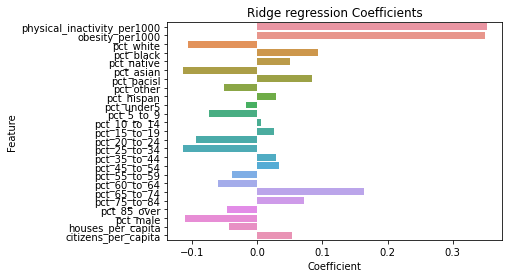

In [34]:
# 3. Plot coefficients
ridge_reg_data = pd.DataFrame([ridge_model_train.coef_, X.columns]).T
ridge_reg_data.columns = ['Coefficient', 'Feature']
ridge_reg_data.head()
# Plot
ax = sns.barplot(x="Coefficient", y="Feature", data=ridge_reg_data)
ax.set_title("Ridge regression Coefficients")
plt.show()

In [35]:
# 4.predict on the training data
ridge_pred_train = ridge_model_train.predict(X_train)

#5.calculate rmse
print("Ridge RMSE: ",rmse(ridge_pred_train, y_train))
ridge_train_rmse = rmse(ridge_pred_train, y_train)

Ridge RMSE:  0.0860987347179903


Next we tune the Ridge hyperparameters.

In [36]:
# 6. Tune Hyperparameters
param_grid = {'alpha': np.arange(.05, 1, .05),
               'normalize': ['True', 'False'],
             'fit_intercept': ['True', 'False'],
             'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

ridge_grid_reg = GridSearchCV(ridge_reg, param_grid, cv=3, iid=False)
ridge_grid_reg.fit(X_train, y_train)

best_ridge_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])

print(ridge_grid_reg.cv_results_["params"][best_ridge_index])

{'alpha': 0.05, 'fit_intercept': 'True', 'normalize': 'True', 'solver': 'auto'}


#### 4. Lasso

In [37]:
# 1.create a model
lasso_reg = Lasso(max_iter=10000,alpha=0.0005)

# 2.fit the model
lasso_model = lasso_reg.fit(X_train, y_train)

[ 0.38432781  0.33565593 -0.08173874  0.08702394  0.         -0.
  0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.00146238 -0.07726084  0.          0.          0.
  0.          0.15361092  0.01676179 -0.         -0.          0.
  0.        ]
0.08473099214033702


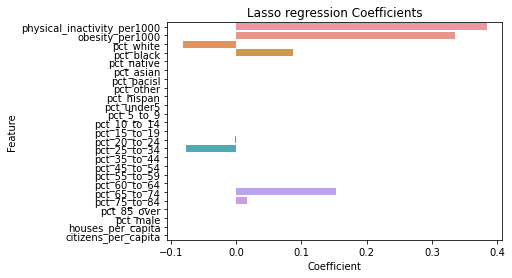

In [38]:
# 3. Plot coefficients
print(lasso_model.coef_)
print(lasso_model.intercept_)

lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T
lasso_reg_data.columns = ['Coefficient', 'Feature']
lasso_reg_data.head()
# Plot
ax = sns.barplot(x="Coefficient", y="Feature", data=lasso_reg_data)
ax.set_title("Lasso regression Coefficients")
plt.show()

In [39]:
# 4.predict on the training data
lasso_pred = lasso_model.predict(X_train)

#5.calculate rmse
print("LASSO RMSE: ",rmse(lasso_pred, y_train))

LASSO RMSE:  0.0876996175978245


Next we tune the hyperparameters using the training set.

In [40]:
# 6. Tune Hyperparameters
param_grid = {'alpha': np.arange(.00005, 0.01, .005),
               'normalize': ['True', 'False'],
             'fit_intercept': ['True', 'False'],
             'selection': ['cyclic', 'random']}

lasso_grid_reg = GridSearchCV(lasso_reg, param_grid, cv=3, iid=False)
lasso_grid_reg.fit(X_train, y_train)

best_lasso_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])

print(lasso_grid_reg.cv_results_["params"][best_lasso_index])

{'alpha': 5e-05, 'fit_intercept': 'True', 'normalize': 'True', 'selection': 'random'}


#### 5. K-Nearest neighbors

In [41]:
# 1.create a model
neigh_reg = KNeighborsRegressor(n_neighbors=5)

# 2.fit the model
neigh_model=neigh_reg.fit(X_train, y_train)

# 3.predict on the training data
neigh_pred = neigh_model.predict(X_train)

#5.calculate rmse
print("Nearest neighbors RMSE: ",rmse(neigh_pred, y_train))

Nearest neighbors RMSE:  0.07654560118464404


Tune hyperparameters

In [42]:
# 6. Tune Hyperparameters
param_grid = {'weights': ['uniform', 'distance'], 
              'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}

neigh_grid_reg = GridSearchCV(neigh_reg, param_grid, cv=3, iid=False)
neigh_grid_reg.fit(X_train, y_train)

best_neigh_index = np.argmax(neigh_grid_reg.cv_results_["mean_test_score"])

print(neigh_grid_reg.cv_results_["params"][best_neigh_index])

{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}


## 5. Validate and Refine Model

### 5.1 Predict on the Validation Set

For each of the models below, we take the best model tuned above on the training data, and use it to predict on the validation data. We then report the RMSE for the validation data and plot the actual vs. predicted results.

#### 1. OLS

In [43]:
# reminder of best hyperparameters 
print(lin_grid_reg.cv_results_["params"][best_lin_index])

# predict y on validation set
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_validate)

print('Best CV R^2:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lin_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lin_pred, y_validate))

{'fit_intercept': 'True', 'normalize': 'True'}
Best CV R^2: 0.5024741511438848
Validation R^2: 0.45553445922183755
Validation RMSE 0.09683114997790047


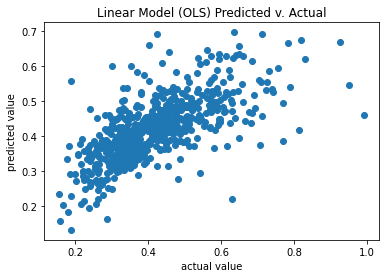

In [44]:
# plot the fit for the validation set
plt.scatter(y = best_lin_pred, x = y_validate)
plt.title('Linear Model (OLS) Predicted v. Actual')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

#### 2. Logistic Regression

In [45]:
# print out best hyperparameters
print(log_grid_reg.cv_results_["params"][best_log_index])

# use to predict on validation set
best_log_pred = log_grid_reg.best_estimator_.predict(X_validate1)

print('Best CV R^2:', max(log_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', log_grid_reg.score(X_validate1, y_validate1))
print('Validation RMSE', rmse(best_log_pred, y_validate1))

{'fit_intercept': True, 'max_iter': 1000}
Best CV R^2: 0.7759914255091104
Validation R^2: 0.7383627608346709
Validation RMSE 0.5115048769712065


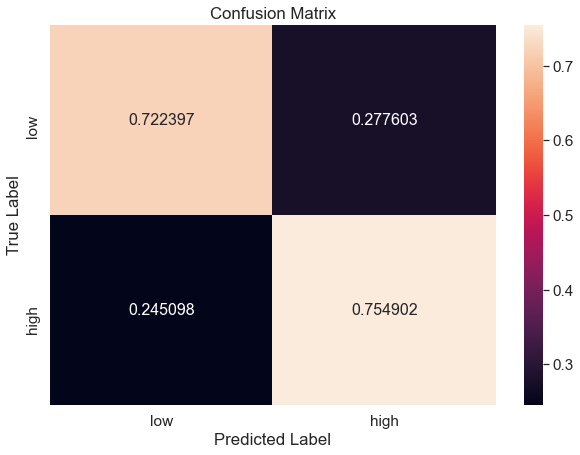

In [46]:
# show a confusion matrix 
cf_matrix = confusion_matrix(y_validate1, best_log_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "low", 1: "high"})
df_cm.index = ["low", "high"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#plt.scatter(x = y_validate1, y = best_log_pred)
#plt.title('Logistic Regression Model')
#plt.xlabel('actual values')
#plt.ylabel('predicted values')
#plt.show()

#### 3. Ridge Regression

In [47]:
# print best hyperparameters 
print(ridge_grid_reg.cv_results_["params"][best_ridge_index])

# predict on the validation set 
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)

print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_ridge_pred, y_validate))

{'alpha': 0.05, 'fit_intercept': 'True', 'normalize': 'True', 'solver': 'auto'}
Best CV R^2: 0.5060747538047682
Validation R^2: 0.45680249811947227
Validation RMSE 0.09671832627319021


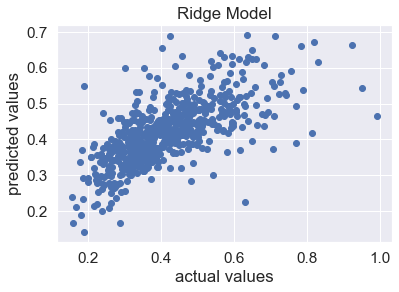

In [48]:
# plot the predictions
plt.scatter(x = y_validate, y = best_ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

#### 4. Lasso

In [49]:
# print the hyperparameters
print(lasso_grid_reg.cv_results_["params"][best_lasso_index])

# use to fit on validation data 
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)

print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lasso_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lasso_pred, y_validate))

{'alpha': 5e-05, 'fit_intercept': 'True', 'normalize': 'True', 'selection': 'random'}
Best CV R^2: 0.5047219594110733
Validation R^2: 0.4423426730147696
Validation RMSE 0.097997184122713


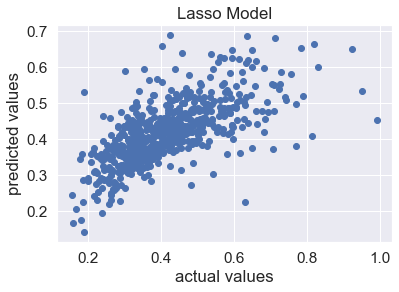

In [50]:
# plot the predictions
plt.scatter(x = y_validate, y = best_lasso_pred)
plt.title('Lasso Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

#### 5. K-Nearest neighbors

In [51]:
# print out the best hyperparameters:
print(neigh_grid_reg.cv_results_["params"][best_neigh_index])

# use to predict on the validation set:
best_neigh_pred = neigh_grid_reg.best_estimator_.predict(X_validate)

print('Best CV R^2:', max(neigh_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', neigh_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_neigh_pred, y_validate))

{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}
Best CV R^2: 0.44599958258949596
Validation R^2: 0.43995140696195834
Validation RMSE 0.09820706808959927


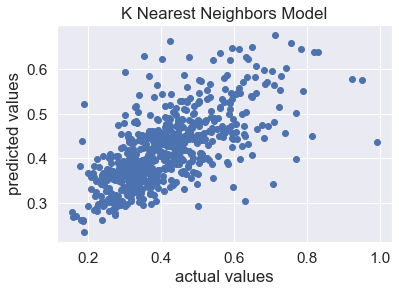

In [52]:
# plot the predictions
plt.scatter(x = y_validate, y = best_neigh_pred)
plt.title('K Nearest Neighbors Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

### 5.2 Feature Selection

One of our models, Lasso, already performs feature selection. The following details attempts to perform feature selection at this point (feature selection is often performed earlier on, before tuning hyperparameters.


#### 1. OLS

We want to select the features that contribute most to our prediction of diabetes per capita. To do this, we rank them by their magnitude (absolute value) and select the top n predictors. We pick n to minimize the RMSE on the validation set. The plot below shows the number of features against the validation RMSE. We find n = 20 to minimize the RMSE.

In [53]:
#Ensure coefficient values are numeric
lin_reg_data['Coefficient'] = pd.to_numeric(arg=lin_reg_data['Coefficient'], errors='coerce')

#select top 20 highset value coefficients
lin_reg_data['AbsCoef'] = lin_reg_data['Coefficient'].abs()

# empty array for results
cols = ["FeatureN", "RMSE"]
lst = []

# loop to try out differenty number of features
for i in range(1,25):
    
    # select number of features 
    OLS_features_top = lin_reg_data.nlargest(i,['AbsCoef'])

    #subset features in training, validation, and test data
    x_train_SF=X_train.loc[:, OLS_features_top['Feature']]
    X_validate_SF=X_validate.loc[:, OLS_features_top['Feature']]
    X_test_SF=X_test.loc[:, OLS_features_top['Feature']]

    #predict on the Training data
    lin_model_SF = lin_reg.fit(x_train_SF, y_train)
    lin_pred_SF = lin_model_SF.predict(x_train_SF)

    # Tune Hyperparameters
    param_grid = {'fit_intercept': ['True', 'False'],
                  'normalize': ['True', 'False']}
    lin_grid_reg_SF = GridSearchCV(lin_reg, param_grid, cv=5, iid=False)
    lin_grid_reg_SF=lin_grid_reg_SF.fit(x_train_SF, y_train)
    best_lin_index_SF = np.argmax(lin_grid_reg_SF.cv_results_["mean_test_score"])

    # predict y on validation set
    best_lin_pred_SF= lin_grid_reg_SF.best_estimator_.predict(X_validate_SF)
        
    # record in df
    #lst.append([i, rmse(best_lin_pred_SF, y_validate)]) 
    lst.append([i,rmse(best_lin_pred_SF, y_validate)])
    
df1 = pd.DataFrame(lst, columns=cols)

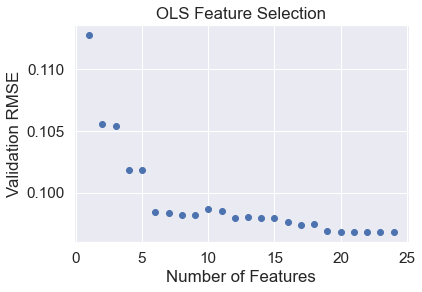

In [54]:
plt.scatter(x = df1["FeatureN"], y = df1["RMSE"])
plt.title('OLS Feature Selection')
plt.xlabel('Number of Features')
plt.ylabel('Validation RMSE')
plt.show()

In [55]:
OLS_features_top = lin_reg_data.nlargest(20,['AbsCoef'])

#subset features in training, validation, and test data
x_train_SF=X_train.loc[:, OLS_features_top['Feature']]
X_validate_SF=X_validate.loc[:, OLS_features_top['Feature']]
X_test_SF=X_test.loc[:, OLS_features_top['Feature']]

#predict on the Training data
lin_model_SF = lin_reg.fit(x_train_SF, y_train)
lin_pred_SF = lin_model_SF.predict(x_train_SF)

# Tune Hyperparameters
param_grid = {'fit_intercept': ['True', 'False'],
              'normalize': ['True', 'False']}
lin_grid_reg_SF = GridSearchCV(lin_reg, param_grid, cv=5, iid=False)
lin_grid_reg_SF=lin_grid_reg_SF.fit(x_train_SF, y_train)
best_lin_index_SF = np.argmax(lin_grid_reg_SF.cv_results_["mean_test_score"])

# predict y on validation set
best_lin_pred_SF= lin_grid_reg_SF.best_estimator_.predict(X_validate_SF)

# 5. calculate validation RMSE

print('RMSE original model on training set:',rmse(lin_pred_train, y_train))
print('RMSE tuned model on validation set:',rmse(best_lin_pred, y_validate))
print("RMSE selected features model on validation set:",rmse(best_lin_pred_SF, y_validate))
    


RMSE original model on training set: 0.08591531671349957
RMSE tuned model on validation set: 0.09683114997790047
RMSE selected features model on validation set: 0.09676766443268613


In [56]:
OLS_features_top.head(n= 20)

,Coefficient,Feature,AbsCoef
1,0.370266,obesity_per1000,0.370266
0,0.354127,physical_inactivity_per1000,0.354127
5,-0.251612,pct_asian,0.251612
2,-0.247886,pct_white,0.247886
22,-0.224150,pct_male,0.224150
19,0.203204,pct_65_to_74,0.203204
6,0.183354,pct_pacisl,0.183354
7,-0.128407,pct_other,0.128407
13,-0.116479,pct_20_to_24,0.116479
14,-0.106743,pct_25_to_34,0.106743


#### 2. Logistic Regression

We start by exploring what is the optimal number of features, and then we insert this number into the RFE function to discover which features should be selected. 

In [58]:
# this code would help us select the number of features to use: 
# from https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

# Feature Extraction with RFE
from sklearn.feature_selection import RFE

#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 11
Score with 11 features: 0.472455


In [59]:
#First: feature selection using the Recursive Feature Elimination (or RFE)
#which works by recursively removing attributes and building a model on those attributes that remain.
# from: https://www.datacamp.com/community/tutorials/feature-selection-python

# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 11)
fit = rfe.fit(X_train1, y_train1)
print("Num Features: %d" % fit.n_features_)

#Place features in table
data = {'Name':  list(X_train.columns),'Selected': list(fit.support_), 'Ranking':list(fit.ranking_)}
df = pd.DataFrame (data, columns = ['Name','Selected','Ranking'])
df=df.drop(df[df['Selected'] == 'False'].index, inplace = False)
print (df)

Num Features: 11
                           Name  Selected  Ranking
0   physical_inactivity_per1000      True        1
1               obesity_per1000      True        1
2                     pct_white      True        1
3                     pct_black      True        1
4                    pct_native     False        2
5                     pct_asian      True        1
6                    pct_pacisl     False       11
7                     pct_other     False        9
8                    pct_hispan     False       14
9                    pct_under5     False       10
10                   pct_5_to_9      True        1
11                 pct_10_to_14     False       12
12                 pct_15_to_19     False       13
13                 pct_20_to_24      True        1
14                 pct_25_to_34     False        3
15                 pct_35_to_44     False        7
16                 pct_45_to_54     False        8
17                 pct_55_to_59     False       15
18            

#### 3. Ridge

We do the same thing for ridge regression as we did for OLS - selecting the lowest number of top coefficients that minimizes the validation RMSE. The number of features we select is 21. 

In [60]:
#Ensure coefficient values are numeric
ridge_reg_data['Coefficient'] = pd.to_numeric(arg=ridge_reg_data['Coefficient'], errors='coerce')

#select top 20 highset value coefficients
ridge_reg_data['AbsCoef'] = ridge_reg_data['Coefficient'].abs()



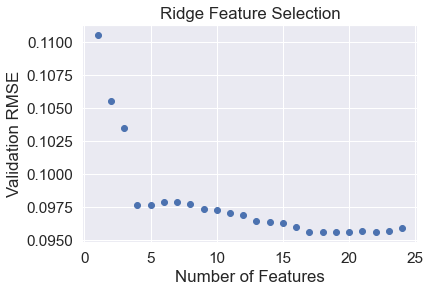

In [110]:
# empty array for results
cols = ["FeatureN", "RMSE"]
lst = []

# loop to try out differenty number of features
for i in range(1,25):
    
    # select to N features
    ridge_features_top = ridge_reg_data.nlargest(i,['Coefficient'])

    #subset features in training data
    X_train_SF=X_train.loc[:, ridge_features_top['Feature']]
    X_validate_SF=X_validate.loc[:, ridge_features_top['Feature']]
    X_test_SF=X_test.loc[:, ridge_features_top['Feature']]

    # #predict on the Training data
    ridge_model_SF = ridge_reg.fit(X_train_SF, y_train)
    ridge_pred_SF = ridge_model_SF.predict(X_train_SF)

    # Tune Hyperparameters

    param_grid = {'alpha': np.arange(0.05, 1, 0.05),
                 'fit_intercept': ['True', 'False'],
                 'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

    ridge_grid_reg_SF = GridSearchCV(ridge_reg, param_grid, cv=3, iid=False)
    ridge_grid_reg_SF.fit(X_train_SF, y_train)

    best_ridge_index_SF = np.argmax(ridge_grid_reg_SF.cv_results_["mean_test_score"])

    # predict y on validation set
    best_ridge_pred_SF= ridge_grid_reg_SF.best_estimator_.predict(X_validate_SF)

    lst.append([i,rmse(best_ridge_pred_SF, y_validate)])
    
df1 = pd.DataFrame(lst, columns=cols)

plt.scatter(x = df1["FeatureN"], y = df1["RMSE"])
plt.title('Ridge Feature Selection')
plt.xlabel('Number of Features')
plt.ylabel('Validation RMSE')
plt.show()
    

In [128]:
# select to N features
ridge_features_top = ridge_reg_data.nlargest(21,['Coefficient'])

#subset features in training data
X_train_SF=X_train.loc[:, ridge_features_top['Feature']]
X_validate_SF=X_validate.loc[:, ridge_features_top['Feature']]
X_test_SF=X_test.loc[:, ridge_features_top['Feature']]

# #predict on the Training data
ridge_model_SF = ridge_reg.fit(X_train_SF, y_train)
ridge_pred_SF = ridge_model_SF.predict(X_train_SF)

# Tune Hyperparameters

param_grid = {'alpha': np.arange(.05, 1, .05),
               'normalize': ['True', 'False'],
             'fit_intercept': ['True', 'False'],
             'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

ridge_grid_reg_SF = GridSearchCV(ridge_reg, param_grid, cv=3, iid=False)
ridge_grid_reg_SF.fit(X_train_SF, y_train)

best_ridge_index_SF = np.argmax(ridge_grid_reg_SF.cv_results_["mean_test_score"])

# predict y on validation set
best_ridge_pred_SF= ridge_grid_reg_SF.best_estimator_.predict(X_validate_SF)

print(ridge_grid_reg_SF.cv_results_["params"][best_ridge_index])
print('RMSE original model on training set:',ridge_train_rmse)
print('RMSE tuned model on validation set:',rmse(best_ridge_pred, y_validate))
print("")
print("RMSE selected features model on training set:",rmse(ridge_pred_SF, y_train))
print("RMSE selected features tuned model on validation set:",rmse(best_ridge_pred_SF, y_validate))

{'alpha': 0.05, 'fit_intercept': 'True', 'normalize': 'True', 'solver': 'auto'}
RMSE original model on training set: 0.0860987347179903
RMSE tuned model on validation set: 0.09671832627319021

RMSE selected features model on training set: 0.0885650861113271
RMSE selected features tuned model on validation set: 0.09551296637502338


#### 4. Lasso

Lasso automatically performs feature selection. The results are as follows: 

In [118]:
lasso_reg_data.columns = ['Coefficient', 'Feature']
print("Lasso picked " + str(sum(lasso_reg_data['Coefficient'] != 0)) + " variables and eliminated the other " +  str(sum(lasso_reg_data['Coefficient'] == 0)) + " variables")

lasso_reg_data.head()


Lasso picked 8 variables and eliminated the other 17 variables


,Coefficient,Feature
0,0.384328,physical_inactivity_per1000
1,0.335656,obesity_per1000
2,-0.0817387,pct_white
3,0.0870239,pct_black
4,0,pct_native


#### 5. K-Nearest Neighbors

In [64]:
# we can use SelectFromModel here too, though I'm not certain how many to select
# from: https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f
#sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
#sel.fit(X_train, y_train)
#sel.get_support()
#selected_feat= X_train.columns[(sel.get_support())]
#len(selected_feat)

### 5.3 Evaluate performance of models on test set

To pick our best model, we compare the RMSE's of each of the model. As the logistic regression was run on a different target variable, we cannot easily compare this model to the other four. However, because we are more interested in predicting cases per capita, as opposed to a binary of below or above medium cases per capita, we disregard this model in our search for the best. The validation RMSE's of each model are printed below. While linear and ridge have very similar RMSEs, the ridge regression is slightly smaller. Additionally, ridge allows us to perform shrinkage, which is a desired feature (IS THIS RIGHT??). Therefore, we select ridge regression as our best performing model and use the hyperparameters tuned from the training data. 

In [119]:
print('Linear regression RMSE', rmse(best_lin_pred_SF, y_validate))
print('Ridge regression RMSE', rmse(best_ridge_pred_SF, y_validate))
print('LASSO regression RMSE', rmse(best_lasso_pred, y_validate))
print('k-Nearest Neighbor RMSE', rmse(best_neigh_pred, y_validate))


Linear regression RMSE 0.09676766443268613
Ridge regression RMSE 0.09551296637502338
LASSO regression RMSE 0.097997184122713
k-Nearest Neighbor RMSE 0.09820706808959927


In [120]:
# Best model
best_pred = ridge_grid_reg_SF.best_estimator_.predict(X_test_SF)
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Test R^2:', ridge_grid_reg.score(X_test, y_test))
print('Test RMSE', rmse(best_pred, y_test))

Best CV R^2: 0.5060747538047682
Test R^2: 0.4779549578005494
Test RMSE 0.09120609535338081


In [121]:
# make predictions for the test set using one model of your choice
final_pred = ridge_grid_reg_SF.predict(X_test_SF)
# calculate the rmse for the final predictions
print('Test set RMSE: ', rmse(final_pred, y_test))

Test set RMSE:  0.09120609535338081


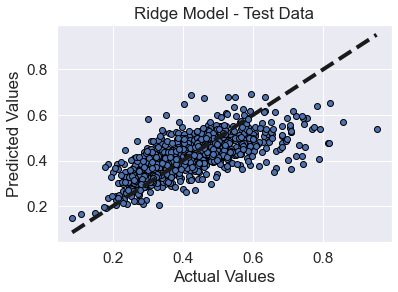

In [122]:
# show fit on the test set 
fig, ax = plt.subplots()
ax.scatter(y_test, final_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
plt.title('Ridge Model - Test Data')
plt.show()


In our analyses, using Ridge regression with the tuned hyperparameters and feature selection produces the lowest RMSE on the test set. This RMSE for ridge regression is lower than the RMSE obtained from the validation set. In section 5.1, we show how well the ridge regression with tuned hyper parameters predicts our outcome on the validation data. According to that visualization, we see that there is a fairly positive relationship between the actual diabetes cases per capita and the predicted diabetes cases per capita. The model appears to do better at predicting diabetes cases per capita for counties with lower cases (around 0.2-0.6 in standardized). Above this threshold, the predicted number of cases per capita is consistently lower than the actual number of cases. This may be due to the fact that there are fewer counties with such a high value of diabetes cases, hence fewer observations for the model to adequately predict them.

Using both a  validation-set and the test-set allows us to evaluate the performance of various models in these two different datasets before using them on the test data. This reiterative process allows our model to train and perform well. This process also allows us to perform further feature selection based on our model fit after initially implementing this step in the training-set and potentially retune our hyperparameters for the best performing model for our final test set.


### 5.4 Implement Cross validation

We use ridge regression to refit our data using a k-fold validation approach. We first run it with the default hyperparameters and k = 5. This gives an RMSE slighlty above the RMSE for the best ridge model above. Similarly to the model above, it predicts well for counties per capita below 150. Above this, the predicted values are consistently lower than the actual values. 

In [123]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

ridge_crossval_pred = cross_val_predict(ridge_reg, X, Y, cv = 5)

print("Ridge cross-validation RMSE:", rmse(ridge_crossval_pred, Y))

Ridge cross-validation RMSE: 0.09076494709918768


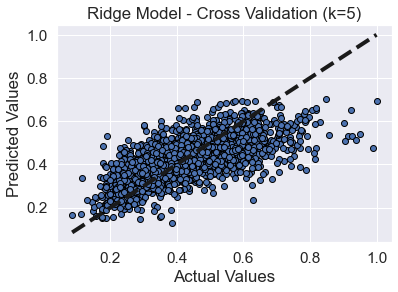

In [124]:
# show fit on the test set 
fig, ax = plt.subplots()
ax.scatter(Y, ridge_crossval_pred, edgecolors=(0, 0, 0))
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
plt.title('Ridge Model - Cross Validation (k=5)')
plt.show()

We also evaluate cross validation with 10 fold.

In [125]:
ridge_crossval_pred2 = cross_val_predict(ridge_reg, X, Y, cv = 10)

print("Ridge cross-validation RMSE:", rmse(ridge_crossval_pred2, Y))

Ridge cross-validation RMSE: 0.09070127390643028


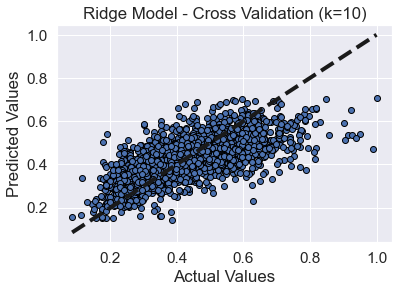

In [126]:
# show fit on the test set 
fig, ax = plt.subplots()
ax.scatter(Y, ridge_crossval_pred2, edgecolors=(0, 0, 0))
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
plt.title('Ridge Model - Cross Validation (k=10)')
plt.show()

Similar to the cross-validation approach with 5 folds, this approach with 10 folds predicts well for counties with diabetes cases per capita below 150. However, the RMSE is slightly smaller with 10 folds. 

While splitting the data ourselves, we are able to preserve a test set on which we implement all the tunning steps we take to obtain an optimal model. On the other hand, cross-validation on the other hand automatically splits the data based on the folds (k) it is provided and holds out one of the subsets of the data for validation. However, unlike our manual approach, cross-validation averages across all the sets to produce the best predictive model.  

We then visualize our model coefficients to determine which characteristics of counties are most predictive of diabetes cases.

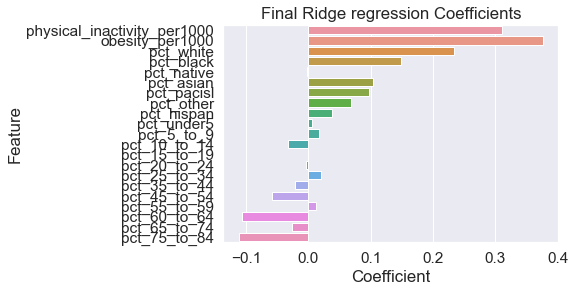

In [127]:
ridge_features_top = ridge_reg_data.nlargest(21,['Coefficient'])

#subset features in training data
X_train_SF=X_train.loc[:, ridge_features_top['Feature']]
X_validate_SF=X_validate.loc[:, ridge_features_top['Feature']]
X_test_SF=X_test.loc[:, ridge_features_top['Feature']]

# #predict on the Training data
ridge_model_SF = ridge_reg.fit(X_test_SF, y_test)


X_test_SF=X_test.loc[:, ridge_features_top['Feature']]
ridge_model_SF = ridge_reg.fit(X_test_SF, y_test)
ridge_final_data = pd.DataFrame([ridge_model_SF.coef_, X.columns]).T
ridge_final_data.columns = ['Coefficient', 'Feature']
ridge_final_data.head()

# drop features not used in this model
ridge_final_data=ridge_final_data.dropna()

# plot
ax = sns.barplot(x="Coefficient", y="Feature", data=ridge_final_data)
ax.set_title("Final Ridge regression Coefficients")
plt.show()

## 6. Discussion Questions

### 6.1 What is bias-variance tradeoff Why is it relevant to machine learning problems like this one?

The bias-variance tradeoff refers to the generalization problem in traditional regression models compared to machine learning algorithms. In traditional regression models, where we are often interested in inferring associations, rather than predictions, we often trade off some variance for low bias in our estimation. However, this means that our results are only specific to the sample on which we run the regression. What machine learning allows us to do is trade off some bias for variance so that the prediction model can perform well in outside samples.

### 6.2 Define overtting, and why it matters for machine learning. How can we address it?

In general, machine learning methods are very good in recognizing patterns. Hence, they are more likely to overfit the data. Overfitting occurs when our model captures every pattern in the sample data, including patterns that do not represent a true relationship/distribution and would otherwise be considered random noise. This masks the true underlying trend in the data. Although this may mean that  the within-sample predictions will be very accurate, it will lead to poor prediction out of sample because the model has trained too well on noise, rather than true signal. 
We can address this issue in several ways. First, we should parse out our data into training, validation, and test sets so that we are able to evaluate model performance in multiple ways. We can ensure that we only include features that matter for the prediction in the model, based on both content area knowledge and data-based techniques. The more features we have, the more variance we introduce in the model and we should aim to minimize the variance in order for the model to make accurate predictions. Finally, we can tune the hyperparameters in our ML models so that they capture the least variance, reducing random error.


### 6.3. Discussion of analyses results

In our analysis we have aimed to identify which counties should be selected for a diabetes pilot program. We do this by predicting diabetes cases per capita for each county, based on various demographic characteristics of the county (distribution of people by race, sex, age), as well as other likely important factors such as physical inactivity number and obesity. 

We started with data on around 3000 counties. We split this 60:20:20 into training:validation:test data in order to fit various models and compare them based on fit. We trained five different models and tuned their hyperparameters on the training data. Then, using the validation data, we performed feature selection and compared all five models on their validation RMSE. We end up selecting a ridge regression model, with standardized data, a fitted intercept, and a regularization strength of 0.05. We selected 21 features based on their influence on the prediction and the lowest RMSE produced by excluding features. These selected features had coefficients that were top 87% of the rest of the coefficients initially included. We ran this final model on our test data, which we had not used up until this point, and we report the final fit above. In general, our model does a good job predicting diabetes cases per capita for counties with low to moderate cases of diabetes (relative to other counties) but fairs worse for counties with the highest number of cases. For these counties, our model underpredicts the number of cases per capita. 

We would prioritize the counties that have the highest predicted rates of diabetes per capita for the pilot program. We take into account race, age, and gender, which are important predictors in our final model. It is possible that the counties we select for the pilot program would change if we were to deliberately exclude these predictors. However, it is also possible that other strong predictors, such as physical inactivity and obesity rates, are highly correlated with race and age, which means our recommended counties would not change. 

Based on this coefficient plot (shown above), we see that the most important predictors in our model are physically inactivity per capita and obesity per capita, behavioural factors that affect diabetes. Other predictors that capture structural factors, such as the distribution of population by race, are also important. We note that old age is negatively associated with higher cases per capita, which we find counter intuitive based on domain knowledge of diabetes. Overall, if we consider features such as physical inactivity and concentration of different racial groups as proxies for structural factors, this may mean that we need to better target countries with the scarce availability of parks and recreational spaces and historically disenfranchised/marginalized populations. 

We would not be content deploying this model in the real world because it is the worst at predicting the counties with highest rates of diabetes per capita - the exact counties that need the pilot program. Our model would instead recommend counties that are at lower risk for the pilot problem, leaving out those that are most in need of intervention. In addition, although we are able to see which predictors are more strongly associated with cases per capita, this does not mesh with our intuition of what factors are associated with diabetes (such as old age).  
